Rows: 935 Columns: 8
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl  (7): ANET, AXP, IR, ODFL, PCAR, WIRE, WTS
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date,ANET,AXP,IR,ODFL,PCAR,WIRE,WTS
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-06-01,58.6600,91.93219,28.66674,165.6877,42.43661,47.75708,80.07024
2020-06-02,57.6125,94.13666,28.75644,163.4469,42.61652,49.09280,81.54997
2020-06-03,57.8175,100.15145,30.69015,164.3551,43.31297,49.82047,84.09079
2020-06-04,57.1650,101.23470,30.58051,163.8023,43.92815,50.79734,84.07133
2020-06-05,58.7925,104.26585,33.13221,167.4447,45.23979,52.66138,88.71491
2020-06-08,57.9475,108.00963,34.91639,164.7203,45.75050,53.39902,88.58838


      ANET                AXP                   IR           
 Min.   :-0.171047   Min.   :-0.0901258   Min.   :-0.070014  
 1st Qu.:-0.011506   1st Qu.:-0.0107740   1st Qu.:-0.008793  
 Median : 0.001057   Median : 0.0007847   Median : 0.000618  
 Mean   : 0.001621   Mean   : 0.0008973   Mean   : 0.001198  
 3rd Qu.: 0.013816   3rd Qu.: 0.0113029   3rd Qu.: 0.011944  
 Max.   : 0.185551   Max.   : 0.1938213   Max.   : 0.080143  
      ODFL                PCAR                WIRE          
 Min.   :-0.138951   Min.   :-0.056515   Min.   :-0.134948  
 1st Qu.:-0.010828   1st Qu.:-0.008049   1st Qu.:-0.013289  
 Median : 0.001469   Median : 0.001209   Median : 0.002231  
 Mean   : 0.001027   Mean   : 0.001001   Mean   : 0.001720  
 3rd Qu.: 0.012885   3rd Qu.: 0.009602   3rd Qu.: 0.015580  
 Max.   : 0.098187   Max.   : 0.099481   Max.   : 0.132139  
      WTS            
 Min.   :-0.1393972  
 1st Qu.:-0.0083893  
 Median : 0.0011428  
 Mean   : 0.0009881  
 3rd Qu.: 0.0110059  
 Max.  

,ANET,AXP,IR,ODFL,PCAR,WIRE,WTS
ANET,0.0006339320,0.0001602786,0.0001826166,0.0001871496,0.0001166338,0.0001863659,0.0001676203
AXP,0.0001602786,0.0004083213,0.0002307235,0.0001509254,0.0001516821,0.0002191495,0.0001806550
IR,0.0001826166,0.0002307235,0.0003582434,0.0001888843,0.0001645107,0.0002592563,0.0002152370
ODFL,0.0001871496,0.0001509254,0.0001888843,0.0004186984,0.0001314730,0.0002324801,0.0001803432
PCAR,0.0001166338,0.0001516821,0.0001645107,0.0001314730,0.0002375477,0.0001719562,0.0001540808
WIRE,0.0001863659,0.0002191495,0.0002592563,0.0002324801,0.0001719562,0.0006574571,0.0002502779
WTS,0.0001676203,0.0001806550,0.0002152370,0.0001803432,0.0001540808,0.0002502779,0.0003223561


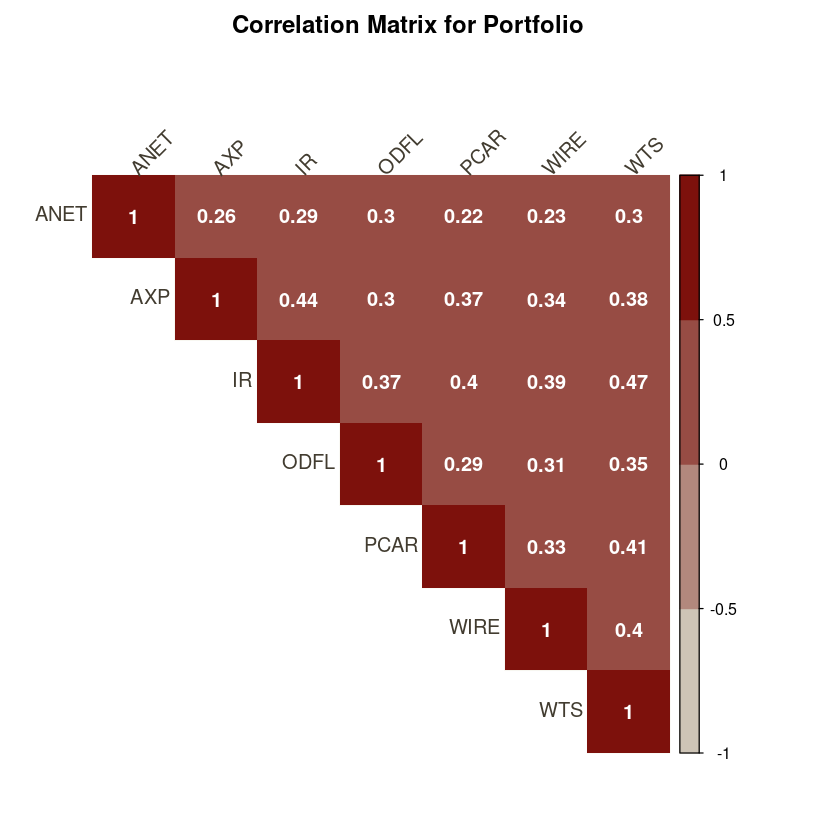

In [55]:
#install.packages("stockPortfolio")  
#install.packages("ggplot2")
#install.packages("reshape2")
#install.packages("quadprog")
#install.packages("corrplot")

#library(stockPortfolio) # Base package for retrieving returns
library(ggplot2) # Used to graph efficient frontier
library(reshape2) # Used to melt the data
library(quadprog) #Needed for solve.QP
library(corrplot)
library(tidyverse)

ealred <- "#7D110C"
ealtan <- "#CDC4B6"
eallighttan <- "#F7F6F0"
ealdark <- "#423C30"

stocks = c(
  "IGV" = 0.10,
  "IDU" = 0.10,
  "ITB" = 0.10,
  "IXP" = 0.10,
  "VEGI" = 0.10,
  "IYE" = 0.10,
  "IBB" = 0.05,
  "IYT" = 0.05)
  
returns <- read_csv('stocks.csv')
head(returns)
returns <- log(lead(returns[-c(1)])/returns[-c(1)])
returns <- returns %>% drop_na()
#returns <- returns %>% select(-'Date')
summary(returns)

# Create simple covariance table
returns %>% cov()
# Create new symbol and assign the Kendall cov table to it
cov.matrix <- returns %>% cov(method = 'kendall')
# Convert the Kendall cov table into a correlation table
cor.matrix <- cov2cor(cov.matrix)

# Create color palette
col1 <- colorRampPalette(c(ealtan, ealred))
corrplot(cor.matrix, method="shade", title="Correlation Matrix for Portfolio",
		 bg=eallighttan, addCoef.col="white", addCoefasPercent=FALSE, 
		 tl.col=ealdark, tl.srt=45, col=col1(4), mar = c(0,1,2,2), 
		 tl.offset=.2, tl.cex=1, type="upper")

In [60]:
#### Efficient Frontier function ####
eff.frontier <- function (returns, short="no", max.allocation=NULL,
                          risk.premium.up=.5, risk.increment=.005){
  # return argument should be a m x n matrix with one column per security
  # short argument is whether short-selling is allowed; default is no (short
  # selling prohibited)max.allocation is the maximum % allowed for any one
  # security (reduces concentration) risk.premium.up is the upper limit of the
  # risk premium modeled (see for loop below) and risk.increment is the
  # increment (by) value used in the for loop
  
  covariance <- returns %>% cov()
  print(covariance)
  n <- ncol(covariance)
  
  # Create initial Amat and bvec assuming only equality constraint
  # (short-selling is allowed, no allocation constraints)
  Amat <- matrix (1, nrow=n)
  bvec <- 1
  meq <- 1
  
  # Then modify the Amat and bvec if short-selling is prohibited
  if(short=="no"){
    Amat <- cbind(1, diag(n))
    bvec <- c(bvec, rep(0, n))
  }
  
  # And modify Amat and bvec if a max allocation (concentration) is specified
  if(!is.null(max.allocation)){
    if(max.allocation > 1 | max.allocation <0){
      stop("max.allocation must be greater than 0 and less than 1")
    }
    if(max.allocation * n < 1){
      stop("Need to set max.allocation higher; not enough assets to add to 1")
    }
    Amat <- cbind(Amat, -diag(n))
    bvec <- c(bvec, rep(-max.allocation, n))
  }
  
  # Calculate the number of loops
  loops <- risk.premium.up / risk.increment + 1
  loop <- 1
  
  # Initialize a matrix to contain allocation and statistics
  # This is not necessary, but speeds up processing and uses less memory
  eff <- matrix(nrow=loops, ncol=n+3)
  # Now I need to give the matrix column names
  colnames(eff) <- c(colnames(returns), "Std.Dev", "Exp.Return", "sharpe")
  
  # Loop through the quadratic program solver
  for (i in seq(from=0, to=risk.premium.up, by=risk.increment)){
    dvec <- colMeans(returns) * i # This moves the solution along the EF
    sol <- solve.QP(covariance, dvec=dvec, Amat=Amat, bvec=bvec, meq=meq)
    eff[loop,"Std.Dev"] <- sqrt(sum(sol$solution*colSums((covariance*sol$solution))))
    eff[loop,"Exp.Return"] <- as.numeric(sol$solution %*% colMeans(returns))
    eff[loop,"sharpe"] <- eff[loop,"Exp.Return"] / eff[loop,"Std.Dev"]
    eff[loop,1:n] <- sol$solution
    loop <- loop+1
  }
  
  return(as.data.frame(eff))
}

# Run the eff.frontier function based on no short and 50% alloc. restrictions
eff <- eff.frontier(returns=returns[-c(1)], short="no", max.allocation=NULL,
                    risk.premium.up=1, risk.increment=.001)

              AXP           IR         ODFL         PCAR         WIRE
AXP  0.0004083213 0.0002307235 0.0001509254 0.0001516821 0.0002191495
IR   0.0002307235 0.0003582434 0.0001888843 0.0001645107 0.0002592563
ODFL 0.0001509254 0.0001888843 0.0004186984 0.0001314730 0.0002324801
PCAR 0.0001516821 0.0001645107 0.0001314730 0.0002375477 0.0001719562
WIRE 0.0002191495 0.0002592563 0.0002324801 0.0001719562 0.0006574571
WTS  0.0001806550 0.0002152370 0.0001803432 0.0001540808 0.0002502779
              WTS
AXP  0.0001806550
IR   0.0002152370
ODFL 0.0001803432
PCAR 0.0001540808
WIRE 0.0002502779
WTS  0.0003223561


In [61]:
# Find the optimal portfolio
eff.optimal.point <- eff[eff$Std.Dev==min(eff$Std.Dev),]
eff.optimal.point1 <- eff[eff$sharpe==max(eff$sharpe),]

print(eff.optimal.point)
print(eff.optimal.point1)

        AXP         IR      ODFL      PCAR WIRE       WTS    Std.Dev
1 0.1290632 0.03392055 0.1674264 0.5017736    0 0.1678163 0.01386439
    Exp.Return     sharpe
1 0.0009963274 0.07186233
             AXP        IR       ODFL      PCAR      WIRE           WTS
195 1.261938e-19 0.1991111 0.09561922 0.4197689 0.2855008 -3.470999e-18
       Std.Dev  Exp.Return     sharpe
195 0.01555984 0.001248005 0.08020678


Warning message in geom_point(data = eff.optimal.point, aes(x = Std.Dev, y = Exp.Return, :
“Ignoring unknown aesthetics: label”
Warning message in geom_point(data = eff.optimal.point1, aes(x = Std.Dev, y = Exp.Return, :
“Ignoring unknown aesthetics: label”


,AXP,IR,ODFL,PCAR,WIRE,WTS,Std.Dev,Exp.Return,sharpe
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.129,0.034,0.167,0.502,0,0.168,0.014,0.001,0.072


,AXP,IR,ODFL,PCAR,WIRE,WTS,Std.Dev,Exp.Return,sharpe
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
195,0,0.199,0.096,0.42,0.286,0,0.016,0.001,0.08


      ANET                AXP                   IR           
 Min.   :-0.171047   Min.   :-0.0901258   Min.   :-0.070014  
 1st Qu.:-0.011506   1st Qu.:-0.0107740   1st Qu.:-0.008793  
 Median : 0.001057   Median : 0.0007847   Median : 0.000618  
 Mean   : 0.001621   Mean   : 0.0008973   Mean   : 0.001198  
 3rd Qu.: 0.013816   3rd Qu.: 0.0113029   3rd Qu.: 0.011944  
 Max.   : 0.185551   Max.   : 0.1938213   Max.   : 0.080143  
      ODFL                PCAR                WIRE          
 Min.   :-0.138951   Min.   :-0.056515   Min.   :-0.134948  
 1st Qu.:-0.010828   1st Qu.:-0.008049   1st Qu.:-0.013289  
 Median : 0.001469   Median : 0.001209   Median : 0.002231  
 Mean   : 0.001027   Mean   : 0.001001   Mean   : 0.001720  
 3rd Qu.: 0.012885   3rd Qu.: 0.009602   3rd Qu.: 0.015580  
 Max.   : 0.098187   Max.   : 0.099481   Max.   : 0.132139  
      WTS            
 Min.   :-0.1393972  
 1st Qu.:-0.0083893  
 Median : 0.0011428  
 Mean   : 0.0009881  
 3rd Qu.: 0.0110059  
 Max.  

,AXP,IR,ODFL,PCAR,WIRE,WTS,Std.Dev,Exp.Return
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.129,0.034,0.167,0.502,0,0.168,0.014,0.001


,AXP,IR,ODFL,PCAR,WIRE,WTS,Std.Dev,Exp.Return
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
195,0,0.199,0.096,0.42,0.286,0,0.016,0.001


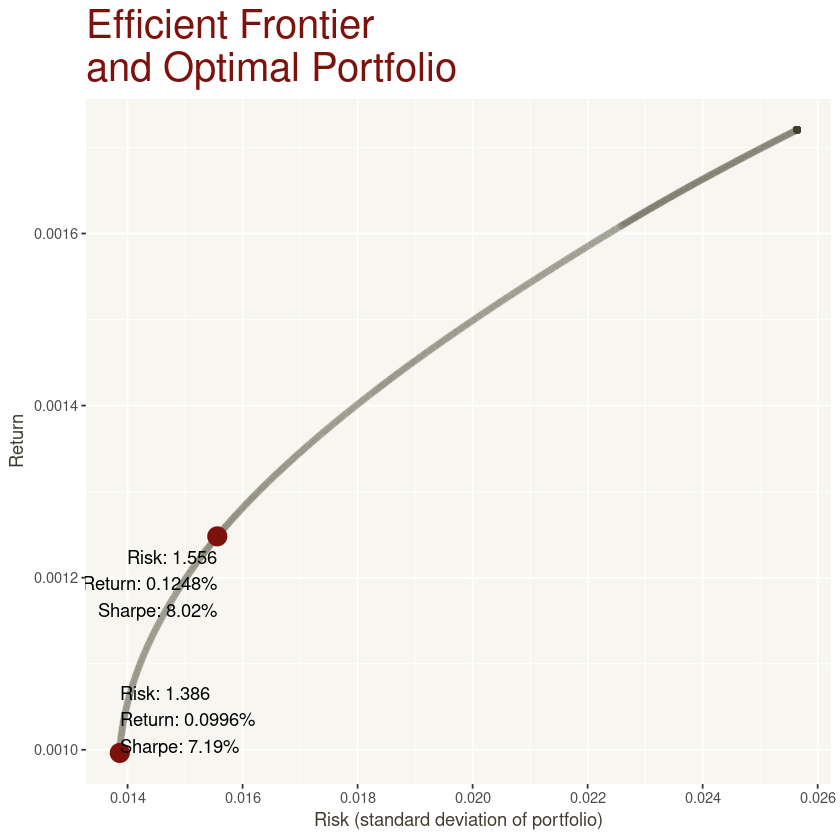

In [62]:
# graph efficient frontier
# Start with color scheme
ealred <- "#7D110C"
ealtan <- "#CDC4B6"
eallighttan <- "#F7F6F0"
ealdark <- "#423C30"

ggplot(eff, aes(x=Std.Dev, y=Exp.Return)) + geom_point(alpha=.1, color=ealdark) +
  geom_point(data=eff.optimal.point, aes(x=Std.Dev, y=Exp.Return, label=sharpe),
             color=ealred, size=5) +
  annotate(geom="text", x=eff.optimal.point$Std.Dev,
           y=eff.optimal.point$Exp.Return,
           label=paste("Risk: ",
                       round(eff.optimal.point$Std.Dev*100, digits=3),"\nReturn: ",
                       round(eff.optimal.point$Exp.Return*100, digits=4),"%\nSharpe: ",
                       round(eff.optimal.point$sharpe*100, digits=2), "%", sep=""),
           hjust=0, vjust=0) +
  geom_point(data=eff.optimal.point1, aes(x=Std.Dev, y=Exp.Return, label=sharpe),
             color=ealred, size=5) +
  annotate(geom="text", x=eff.optimal.point1$Std.Dev,
           y=eff.optimal.point1$Exp.Return,
           label=paste("Risk: ",
                       round(eff.optimal.point1$Std.Dev*100, digits=3),"\nReturn: ",
                       round(eff.optimal.point1$Exp.Return*100, digits=4),"%\nSharpe: ",
                       round(eff.optimal.point1$sharpe*100, digits=2), "%", sep=""),
           hjust=1, vjust=1.2) +
  ggtitle("Efficient Frontier\nand Optimal Portfolio") +
  labs(x="Risk (standard deviation of portfolio)", y="Return") +
  theme(panel.background=element_rect(fill=eallighttan),
        text=element_text(color=ealdark),
        plot.title=element_text(size=24, color=ealred))
#ggsave("Efficient Frontier.png")
round(eff.optimal.point,3) #This gives the minimum variance portfolio
round(eff.optimal.point1,3) #This gives the maximum sharpe ratio portfolio
summary(returns) #Data on each of the assets designated above

#plot(returns)
round(eff.optimal.point[1:length(stocks)], 3)
round(eff.optimal.point1[1:length(stocks)], 3)

In [12]:
returns %>% select(-'Date') %>% cov(method = 'kendall')

,ANET,AXP,IR,ODFL,PCAR,WIRE,WTS
ANET,873234,452344,624660,671288,549798,720932,608712
AXP,452344,873284,455670,483754,291108,433366,515230
IR,624660,455670,873152,685674,560664,612418,697410
ODFL,671288,483754,685674,873276,501784,657170,679742
PCAR,549798,291108,560664,501784,873238,558472,462836
WIRE,720932,433366,612418,657170,558472,873264,590054
WTS,608712,515230,697410,679742,462836,590054,873272


In [37]:
returns <- read_csv('stocks.csv')
log(lead(returns[-c(1)])/returns[-c(1)])

Rows: 935 Columns: 8
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl  (7): ANET, AXP, IR, ODFL, PCAR, WIRE, WTS
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ANET,AXP,IR,ODFL,PCAR,WIRE,WTS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.018018516,0.0236962926,0.0031242674,-1.361633e-02,0.0042305986,0.027585058,0.0183116949
0.003551972,0.0619360194,0.0650800190,5.541090e-03,0.0162099625,0.014713611,0.0306810538
-0.011349677,0.0107579870,-0.0035788823,-3.369184e-03,0.0141034136,0.019418076,-0.0002313833
0.028072449,0.0295023132,0.0801429479,2.199327e-02,0.0294215308,0.036038373,0.0537623344
-0.014476889,0.0352765225,0.0524505320,-1.640442e-02,0.0112258317,0.013909969,-0.0014273117
-0.001683972,-0.0286460004,-0.0569734860,-1.808068e-02,0.0015214523,-0.040962028,-0.0334091273
0.005903072,-0.0397058609,-0.0094125372,8.687936e-03,-0.0276102065,-0.012524725,-0.0311588824
-0.061892775,-0.0738762124,-0.0639286348,-4.998538e-02,-0.0565153082,-0.091281344,-0.0680220960
0.018026647,0.0307592167,0.0151689685,3.998375e-03,0.0080960278,0.014139232,0.0060045968


In [43]:
eff

AXP,IR,ODFL,PCAR,WIRE,WTS,Std.Dev,Exp.Return,sharpe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1290632,0.03392055,0.1674264,0.5017736,0.000000e+00,0.1678163,0.01386439,0.0009963274,0.07186233
0.1282862,0.03534975,0.1673741,0.5016111,-3.469447e-18,0.1673788,0.01386440,0.0009966944,0.07188872
0.1275092,0.03677895,0.1673218,0.5014487,0.000000e+00,0.1669414,0.01386444,0.0009970613,0.07191498
0.1267322,0.03820815,0.1672695,0.5012863,0.000000e+00,0.1665040,0.01386451,0.0009974282,0.07194111
0.1259552,0.03963735,0.1672171,0.5011238,0.000000e+00,0.1660665,0.01386460,0.0009977951,0.07196709
0.1251782,0.04106655,0.1671648,0.5009614,0.000000e+00,0.1656291,0.01386472,0.0009981621,0.07199294
0.1244012,0.04249575,0.1671125,0.5007990,0.000000e+00,0.1651916,0.01386487,0.0009985290,0.07201865
0.1236242,0.04392495,0.1670601,0.5006365,0.000000e+00,0.1647542,0.01386504,0.0009988959,0.07204422
0.1228472,0.04535415,0.1670078,0.5004741,0.000000e+00,0.1643168,0.01386524,0.0009992628,0.07206965


In [28]:
returns %>% cov(method = 'kendall')

,ANET,AXP,IR,ODFL,PCAR,WIRE,WTS
ANET,NA,NA,NA,NA,NA,NA,NA
AXP,NA,NA,NA,NA,NA,NA,NA
IR,NA,NA,NA,NA,NA,NA,NA
ODFL,NA,NA,NA,NA,NA,NA,NA
PCAR,NA,NA,NA,NA,NA,NA,NA
WIRE,NA,NA,NA,NA,NA,NA,NA
WTS,NA,NA,NA,NA,NA,NA,NA


In [29]:
returns

ANET,AXP,IR,ODFL,PCAR,WIRE,WTS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA
0.018018516,-0.0236962926,-0.0031242674,1.361633e-02,-0.0042305986,-0.027585058,-0.0183116949
-0.003551972,-0.0619360194,-0.0650800190,-5.541090e-03,-0.0162099625,-0.014713611,-0.0306810538
0.011349677,-0.0107579870,0.0035788823,3.369184e-03,-0.0141034136,-0.019418076,0.0002313833
-0.028072449,-0.0295023132,-0.0801429479,-2.199327e-02,-0.0294215308,-0.036038373,-0.0537623344
0.014476889,-0.0352765225,-0.0524505320,1.640442e-02,-0.0112258317,-0.013909969,0.0014273117
0.001683972,0.0286460004,0.0569734860,1.808068e-02,-0.0015214523,0.040962028,0.0334091273
-0.005903072,0.0397058609,0.0094125372,-8.687936e-03,0.0276102065,0.012524725,0.0311588824
0.061892775,0.0738762124,0.0639286348,4.998538e-02,0.0565153082,0.091281344,0.0680220960


In [44]:
cov.matrix

,ANET,AXP,IR,ODFL,PCAR,WIRE,WTS
ANET,871420,224588,250066,260726,187486,204620,260026
AXP,224588,871422,383412,258296,320564,298066,333184
IR,250066,383412,871416,321078,352754,340020,411638
ODFL,260726,258296,321078,871420,255454,273368,307542
PCAR,187486,320564,352754,255454,871392,290844,360450
WIRE,204620,298066,340020,273368,290844,871410,351848
WTS,260026,333184,411638,307542,360450,351848,871416
